In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import local_eb_kernel as rk
from scipy.integrate import quad
import timeit

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import rcParams,rc
params = {'backend': 'pdf',
          'savefig.dpi': 200,
          'axes.labelsize': 15,
          'text.fontsize': 15,
          'axes.linewidth' : 2,
          'lines.linewidth' : 2,
          'font.size': 15,
          'xtick.labelsize': 15,
          'ytick.major.pad': 6,
          'xtick.major.pad': 6,
          'ytick.labelsize': 15,
          'text.usetex': True,
          'font.family':'sans-serif',
          'font.sans-serif':'FreeSans'}
rc('text.latex', preamble='\usepackage{sfmath}')
rcParams.update(params)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:
figpath="../../figures/supplementary/healpix_local/"
!mkdir $figpath

In [5]:
nside=64 ; upnside=nside ; npix=h.nside2npix(upnside)
lmax=3*nside ; lmin=2
ell=arange(lmax+1)

odisc=1.*min(180.,180.*(24./lmax))
print odisc

22.5


In [6]:
cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
#cltemp=h.read_cl("../../data/cl_rem3.fits")


cl=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*0] # Reverse E and B spectra

#cl=[cltemp[0],cltemp[2],cltemp[1],cltemp[3]*0] # Reverse E and B spectra
#figpath="../article/figures/complementary/"

random.seed(0) ; tqu=h.synfast(cl,nside,pol=True,new=True,verbose=False)

# Get teb maps from Healpix.
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; teb=h.alm2map(alm,upnside,pol=False,verbose=False)

# Get data power spectrum.
cld=h.alm2cl(alm)

# Get Q/U corresponding to E and B modes.
alm[2][:]=0.0 ; equ=h.alm2map(alm,nside=nside,pol=True,verbose=False)
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; alm[1][:]=0.0 ; bqu=h.alm2map(alm,nside=nside,pol=True,verbose=False)

fl=ones(3*nside+1,float) ; fl[:lmin+1]=0

ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

In [7]:
def return_disc_mask(discsize,apow,nside,cpix):
    mask=zeros(h.nside2npix(nside),float)
    # The coordinate of the pixel center updated to that in the mask resolution
    theta0=h.pix2ang(nside,cpix)[0] ; phi0=h.pix2ang(nside,cpix)[1]

    pixnum=np.arange(h.nside2npix(nside))
    theta=h.pix2ang(nside,pixnum)[0] ; phi=h.pix2ang(nside,pixnum)[1]
    dotprod=np.sin(theta)*np.sin(theta0)*np.cos(phi-phi0)+np.cos(theta)*np.cos(theta0)
    dtheta=np.arccos(dotprod)*180./np.pi

    for i in range(h.nside2npix(nside)):
        if dtheta[i] <= (discsize-apow):
            mask[i]=1.
        elif dtheta[i] > (discsize-apow) and dtheta[i] <= discsize:
            mask[i]=np.cos((dtheta[i]-(discsize-apow))*np.pi/(2.*apow))**2.
            
    return mask

In [8]:
rteb=[zeros(npix,float),zeros(npix,float),zeros(npix,float)]
for i in range(npix):
    #print (i*1./npix)*100
    mask=return_disc_mask(odisc,3,nside,i)
    alm=h.map2alm(tqu*mask,lmax=3*nside,pol=True)
    temp_teb=h.alm2map(alm,nside,pol=False,verbose=False)
    rteb[1][i]=temp_teb[1][i]
    rteb[2][i]=temp_teb[2][i]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos


In [11]:
y=rk.real_space_queb_kernels(nside,tmax=2.2*odisc,maxlmax=3*nside,sampling=2500)
y.calc_qu2eb_rad_kernel(lmax,lmin)
y.calc_qu2queb_rad_kernel(lmax,lmin)

disc=1.0*odisc ; y.setup_taper(disc,3.) ; y.setup_fn_rad_ker()
rteb1=y.convert_qu2eb(tqu,discsize=disc)

In [13]:
mask[:]=1.
clteb=h.alm2cl(h.map2alm(teb*mask,lmax=3*nside,pol=False))
clrteb=h.alm2cl(h.map2alm(rteb*mask,lmax=3*nside,pol=False))
clrteb1=h.alm2cl(h.map2alm(rteb1*mask,lmax=3*nside,pol=False))

<IPython.core.display.Javascript object>


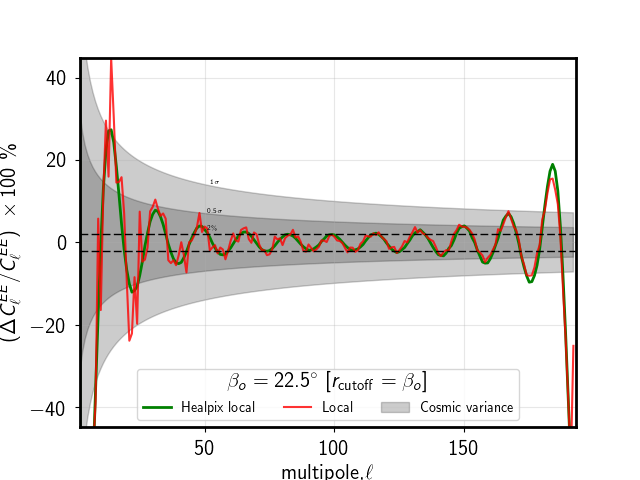

In [20]:
figure()
plot((clrteb[1]-clteb[1])*100/clteb[1],"g-",lw=2,label=r"Healpix local")
plot((clrteb1[1]-clteb[1])*100/clteb[1],"r-",lw=1.5,label=r"Local",alpha=0.8)
fill_between(ell,-sqrt(2./(2.*ell+1))*clteb[1]*100/clteb[1],sqrt(2./(2.*ell+1))*clteb[1]*100/clteb[1],color="black",alpha=0.2,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*clteb[1]*100/clteb[1],0.5*sqrt(2./(2.*ell+1))*clteb[1]*100/clteb[1],color="black",alpha=0.2,label="")


ylim(-45,45)
xlim(2,3*nside+1)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{EE}_{\ell}/C^{EE}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=3,title=r"$\beta_o=" + str(odisc) + "^{\circ}$" + r" $[r_{\rm cutoff}=\beta_o]$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
#axvline(2*nside,-45,45,linestyle="dashed",alpha=1,color="m",lw=1)
grid(alpha=0.3,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)
savefig(figpath + "convolution-err-ee-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


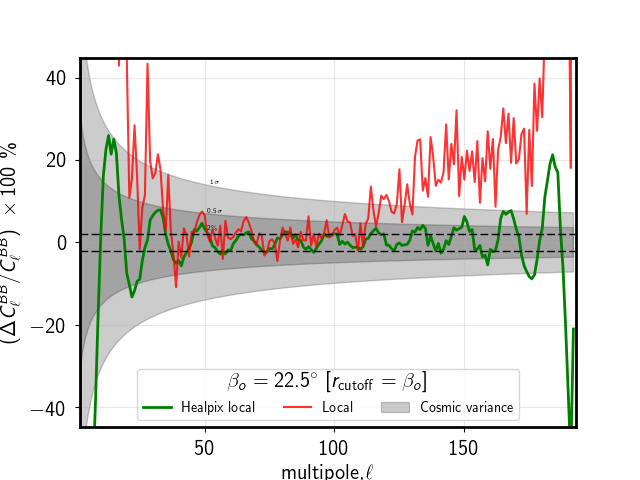

In [21]:
figure()
plot((clrteb[2]-clteb[2])*100/clteb[2],"g-",lw=2,label=r"Healpix local")
plot((clrteb1[2]-clteb[2])*100/clteb[2],"r-",lw=1.5,label=r"Local",alpha=0.8)
fill_between(ell,-sqrt(2./(2.*ell+1))*clteb[2]*100/clteb[2],sqrt(2./(2.*ell+1))*clteb[2]*100/clteb[2],color="black",alpha=0.2,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*clteb[2]*100/clteb[2],0.5*sqrt(2./(2.*ell+1))*clteb[2]*100/clteb[2],color="black",alpha=0.2,label="")
ylim(-45,45)
xlim(2,3*nside+1)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{BB}_{\ell}/C^{BB}_{\ell}) ~\times 100 ~\%$")
legend(loc=0,fontsize=10,ncol=3,title=r"$\beta_o=" + str(odisc) + "^{\circ}$"+ r" $[r_{\rm cutoff}=\beta_o]$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
#axvline(2*nside,-45,45,linestyle="dashed",alpha=1,color="m",lw=1)
grid(alpha=0.3,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)
savefig(figpath + "convolution-err-bb-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

In [22]:
h.write_map(figpath + "conv_err_healpix_local_nside64_betao30deg.fits",rteb)
h.write_map(figpath + "conv_err_python_local_nside64_betao30deg.fits",rteb1)

<IPython.core.display.Javascript object>


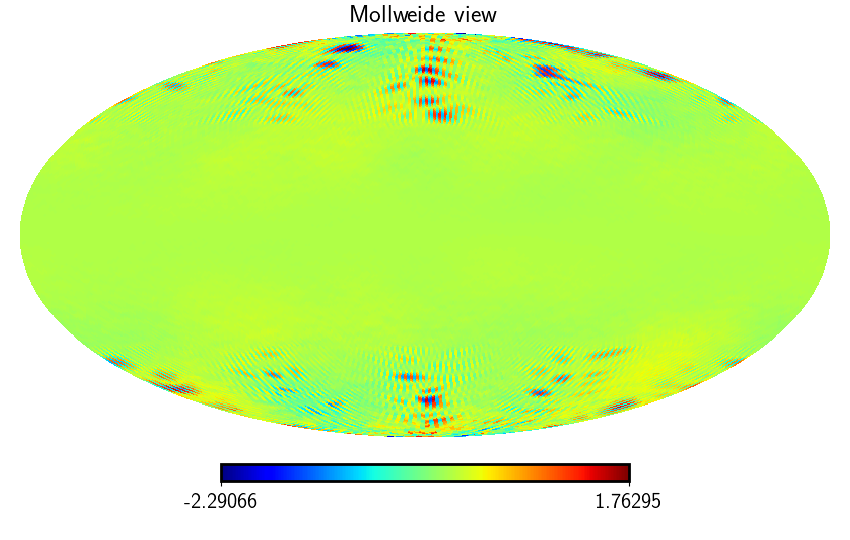

In [25]:
h.mollview(rteb[1]-rteb1[1])